# 分析

In [ ]:
### 分析图，带colorbar
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [ ]:
### compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes 
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

In [1]:
import pandas as pd
import numpy as np

In [3]:
adr='D:\code_study\handson-ml-code\datasets\housing\housing.csv'
housing=pd.read_csv(adr)

In [6]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)#Replace values where the condition is False.

# sklearn

`Scikit-Learn Design`:
- Estimators,estimate some parameters based on a dataset,**fit()**
- Transformers,Some estimators (such as an imputer) can also transform a dataset,**fit_transform()**
- Predictors,some estimators are capable of making predictions given a dataset,**predict(),score()**

All the estimator’s hyperparameters are accessible directly via public
instance variables (e.g., imputer.strategy), and all the estimator’s learned
parameters are also accessible via public instance variables with an underscore
suffix (e.g., imputer.statistics_).

## Transformations

### Imputer

In [ ]:
### 用中位数填充Nan值,can only be computed on numerical attributes

from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
imputer.fit(housing_num)
imputer.statistics_#存储的所有中位数
X = imputer.transform(housing_num)# return plain Numpy array containing the transformed features

### OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
# fit_transform() expects a 2D array
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))# the output is a SciPy sparse matrix, instead of a NumPy arra
housing_cat_1hot.toarray()

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)#returns a dense NumPy array by default,or setb sparse_output=True

### Custom Transformers

- create a class and implement three methods: fit()(returning self), transform(), and fit_transform()
- can get the last one for free by simply adding TransformerMixin as a base class
- add BaseEstimator as a base class (and avoid \*args and \*\*kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

- Note that scaling the target values is generally not required.`StandardScaler`: zero mean,unit variance
- min-max scaling (normalization) and standardization.`MinMaxScaler`: feature_range,not restricted to 0-1
     

## Training Model

- **underfitting**: the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough (select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model)
- you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation

### `Regression`

#### LinearRegression
```python
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
```

#### DecisionTree

capable of finding complex nonlinear relationships
```python
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
```

#### Random Forests

Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions.
```python
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
```

### `Classification`

#### Stochastic Gradient Descent (SGD)

- capable of handling very large datasets efficiently
- deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

```python
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])
```

#### Random Forest Classifier

```python
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
forest_clf.predict_proba([some_digit])
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
forest_clf.predict_proba([some_digit])#get the list of probabilities that the classifier assigned to each instance for each class
```

#### Multiclass Classification

- Random Forest classifiers or naive Bayes classifiers handling multiple classes directly
- one-versus-all (OvA) N binary models: select the class whose classifier outputs the highest score
- one-versus-one (OvO) N × (N – 1) / 2 classifiers: Support Vector Machine 

```python
###force ScikitLearn to use one-versus-one or one-versus-all
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

```

#### Multilabel Classification

```python
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()#supports multilabel classification
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])
### the following cell may take a very long time (possibly hours depending on your hardware).
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")#average F1 score across all labels
'''
set average="weighted" for unequal score for different labels
'''
```

#### Multioutput Classification



#### measure performance
1. Accuracy

```python
'''
下面两段代码分别实现Measuring Accuracy Using Cross-Validation
'''
###sklearn自带
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

###自己定义，结果应该与上面相同
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
```
<font color='red'>accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others)</font>

2. Confusion Matrix

```python
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
```
Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

3. Precision and Recall

```python
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

'''
It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers.
'''
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
'''
Precision/Recall Tradeoff，decide threshold(which decide P or N)
'''
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()
### Precision versus recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

'''
aim for 90% precision,instead of calling the classifier’s predict() method
'''
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)
```

4. The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.plots the true positive rate (another name for recall) against the false positive rate.

```python
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
### draw picture
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

'''
One way to compare classifiers is to measure the area under the curve (AUC)
'''
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)
```
<font color='red'>prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise</font>

#### Error Analysis


```python
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
### only focus on error
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()
```

### fine tune the model
- `Grid Search`


```python
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_ #get the best combination of parameters
grid_search.best_estimator_ #get the best estimator
# the score of each hyperparameter combination tested during the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

### 利用RandomForestRegressor进行feature selection
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances
### display these importance scores next to their corresponding attribute names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)
```

- `RandomizedSearchCV`: when the hyperparameter search space is large

```python
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
#查看各个模型的评分
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

```


```python
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)#randomly splits the training set into 10 distinct subsets called folds
tree_rmse_scores = np.sqrt(-scores)#

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)
```

##### Evaluation the model's performance

run your full_pipeline to transform the data (call transform(), not fit_transform()!)

In [ ]:
### A full pipeline with both preparation and prediction
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

```python
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
```

```python
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
```python




##### save model

You should save every model you experiment with, so you can come back easily to any model you want.Make sure you save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. You can easily save Scikit-Learn models by using Python’s pickle module, or using sklearn.externals.joblib, which is more efficient at serializing large NumPy arrays:
```python
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")
```

### Pipeline

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method).

-  `FeatureUnion`:You give it a list of transformers (which can be entire transformer pipelines), and when its transform() method is called it runs each transformer’s transform() method in parallel, waits for their output, and then concatenates them and returns the result (and of course calling its fit() method calls all each transformer’s fit() method)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [ ]:
### TRANSFORM ###

X = train.drop('Loan_Status', axis=1)
y = train['Loan_Status']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

###
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train.select_dtypes(include=['object']).drop(['Loan_Status'], axis=1).columns

### 
from sklearn.compose import ColumnTransformerpreprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### CLASSIFIER ### 

from sklearn.ensemble import RandomForest

Classifierrf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


### MODEL SELECTION ###

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))
    
'''
The pipeline can also be used in grid search to find the best performing parameters. 
To do this you first need to create a parameter grid for your chosen model. 
One important thing to note is that you need to append the name that 
you have given the classifier part of your pipeline to each parameter name.
'''
param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy']
    
from sklearn.model_selection import GridSearchCV
    
CV = GridSearchCV(rf, param_grid, n_jobs= 1)
                  
CV.fit(X_train, y_train)  
print(CV.best_params_)    
print(CV.best_score_)

### Feature Selection

- Pearson correlation as a feature ranking mechanism only sensitive to a linear relationship
- Mutual information and maximal information coefficient (MIC)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = pd.read_csv("D://Blogs//train.csv")
X = data.iloc[:,0:20]  #independent columns，X should be nonnegative!!!
y = data.iloc[:,-1]    #target column i.e price range

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

#### use model do feature selection

-  based on the idea that when all features are on the same scale

`simple linear regression`:independent features
```python 
from sklearn.linear_model import LinearRegression
import numpy as np
 
np.random.seed(0)
size = 5000
 
#A dataset with 3 features
X = np.random.normal(0, 1, (size, 3))
#Y = X0 + 2*X1 + noise
Y = X[:,0] + 2*X[:,1] + np.random.normal(0, 2, size)
lr = LinearRegression()
lr.fit(X, Y)
 
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)
 
print("Linear model:", pretty_print_linear(lr.coef_))
```
`multicollinearity problem`:correlated features
**Regularized models: two widely used regularization methods are L1 and L2 regularization, also called lasso and ridge regression when applied in linear regression.**

1. L1 regularization / Lasso

For regression, Scikit-learn offers Lasso for linear regression and Logistic regression with L1 penalty for classification. coefficients (and thus feature ranks) can vary significantly even on small data changes when there are correlated features in the data

```python
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
  
boston = load_boston()
scaler = StandardScaler()
X = scaler.fit_transform(boston["data"])
Y = boston["target"]
names = boston["feature_names"]
  
lasso = Lasso(alpha=.3)
lasso.fit(X, Y)
  
print("Lasso model: ", pretty_print_linear(lasso.coef_, names, sort = True))

```
2. L2 regularization / Ridge regression

it forces the coefficient values to be spread out more equally, coefficients do not fluctuate on small data changes as is the case with unregularized or L1 models, more useful for feature *interpretation*: a predictive feature will get a non-zero coefficient, which is often not the case with L1.

# other functions

NameError: name 'np' is not defined

In [3]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

## titanic case

In [10]:
#This librarys is to work with matrices
import pandas as pd 
# This librarys is to work with vectors
import numpy as np
# This library is to create some graphics algorithmn
import seaborn as sns
# to render the graphs
import matplotlib.pyplot as plt
# import module to set some ploting parameters
from matplotlib import rcParams
# Library to work with Regular Expressions
import re

# This function makes the plot directly on browser
%matplotlib inline

# Seting a universal figure size 
rcParams['figure.figsize'] = 10,6

df_train=pd.read_csv(r'E:\data_study\data_kaggle\titanic\train.csv')
df_test = pd.read_csv(r'E:\data_study\data_kaggle\titanic\test.csv')

In [14]:
df_train['Title'] = df_train.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
df_test['Title'] = df_test.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

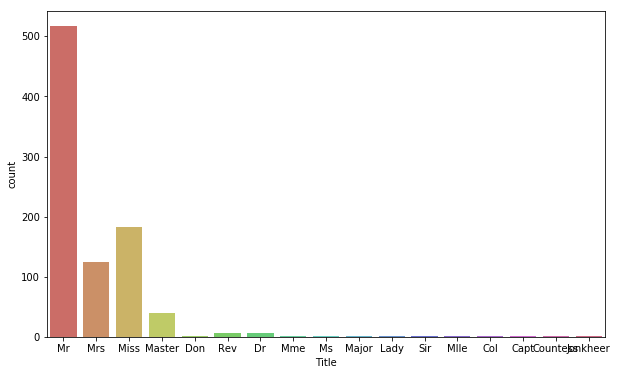

In [12]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

import seaborn as sns
sns.countplot(x='Title', data=df_train, palette="hls")

In [15]:
#Now, I will identify the social status of each title

Title_Dictionary = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Lady" :      "Royalty",
        "Mme":        "Mrs",
        "Ms":         "Mrs",
        "Mrs" :       "Mrs",
        "Mlle":       "Miss",
        "Miss" :      "Miss",
        "Mr" :        "Mr",
        "Master" :    "Master"
                   }
    
# we map each title to correct category
df_train['Title'] = df_train.Title.map(Title_Dictionary)
df_test['Title'] = df_test.Title.map(Title_Dictionary)

Chances to survive based on titles: 
Title
Master     0.575000
Miss       0.701087
Mr         0.156673
Mrs        0.795276
Officer    0.277778
Royalty    0.500000
Name: Survived, dtype: float64


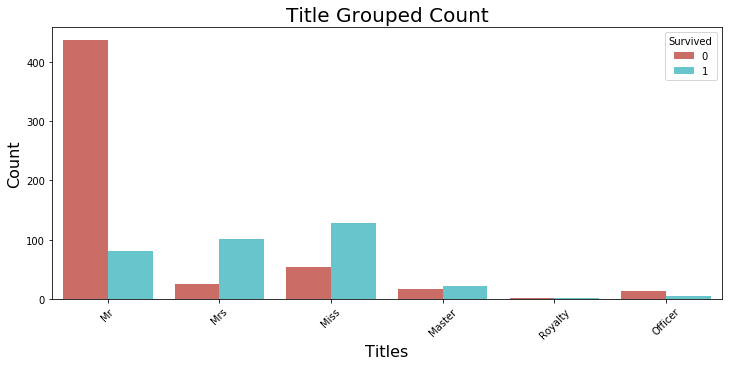

In [16]:
#printing the chance to survive by each title
print("Chances to survive based on titles: ") 
print(df_train.groupby("Title")["Survived"].mean())

# figure size
plt.figure(figsize=(12,5))

#Plotting the count of title by Survived or not category
sns.countplot(x='Title', data=df_train, palette="hls",
              hue="Survived")
plt.xlabel("Titles", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Title Grouped Count", fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [19]:
import pandas as pd
import csv

def get_one_page(page):
    url = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_%s.html' % (str(page))
    tb = pd.read_html(url, skiprows=[0, 1])[0]  # 跳过前两行
    return tb.drop([len(tb)-1])  # 去掉最后一行


with open(r'D:\ssq.csv', 'w', encoding='utf-8-sig', newline='') as f:
    csv.writer(f).writerow(['开奖日期', '期号', '中奖号码', '销售额(元)', '中奖注数一等奖', '中奖注数二等奖', '详细'])

for i in range(1,117):  # 目前116页数据
    get_one_page(i).to_csv(r'D:\ssq.csv', mode='a', encoding='utf_8_sig', header=0, index=0)
    print('第'+str(i)+'页抓取完成')

第1页抓取完成
第2页抓取完成
第3页抓取完成
第4页抓取完成
第5页抓取完成
第6页抓取完成
第7页抓取完成
第8页抓取完成
第9页抓取完成
第10页抓取完成
第11页抓取完成
第12页抓取完成
第13页抓取完成
第14页抓取完成
第15页抓取完成
第16页抓取完成
第17页抓取完成
第18页抓取完成
第19页抓取完成
第20页抓取完成
第21页抓取完成
第22页抓取完成
第23页抓取完成
第24页抓取完成
第25页抓取完成
第26页抓取完成
第27页抓取完成
第28页抓取完成
第29页抓取完成
第30页抓取完成
第31页抓取完成
第32页抓取完成
第33页抓取完成
第34页抓取完成
第35页抓取完成
第36页抓取完成
第37页抓取完成
第38页抓取完成
第39页抓取完成
第40页抓取完成
第41页抓取完成
第42页抓取完成
第43页抓取完成
第44页抓取完成
第45页抓取完成
第46页抓取完成
第47页抓取完成
第48页抓取完成
第49页抓取完成
第50页抓取完成
第51页抓取完成
第52页抓取完成
第53页抓取完成
第54页抓取完成
第55页抓取完成
第56页抓取完成
第57页抓取完成
第58页抓取完成
第59页抓取完成
第60页抓取完成
第61页抓取完成
第62页抓取完成
第63页抓取完成
第64页抓取完成
第65页抓取完成
第66页抓取完成
第67页抓取完成
第68页抓取完成
第69页抓取完成
第70页抓取完成
第71页抓取完成
第72页抓取完成
第73页抓取完成
第74页抓取完成
第75页抓取完成
第76页抓取完成
第77页抓取完成
第78页抓取完成
第79页抓取完成
第80页抓取完成
第81页抓取完成
第82页抓取完成
第83页抓取完成
第84页抓取完成
第85页抓取完成
第86页抓取完成
第87页抓取完成
第88页抓取完成
第89页抓取完成
第90页抓取完成
第91页抓取完成
第92页抓取完成
第93页抓取完成
第94页抓取完成
第95页抓取完成
第96页抓取完成
第97页抓取完成
第98页抓取完成
第99页抓取完成
第100页抓取完成
第101页抓取完成
第102页抓取完成
第103页抓取完成
第104页抓取完成
第105页抓取完成
第106页抓取完成
第107页抓取完成
第108页抓取完成
第109页抓取完成
第110页抓取完成
第111页抓取完

In [20]:
ssq=pd.read_csv(r'D:\ssq.csv')

In [23]:
ssq.head()

,开奖日期,期号,中奖号码,销售额(元),中奖注数一等奖,中奖注数二等奖,详细
0,2019-06-27,2019074,12 21 27 29 31 33 04,339313032,4 (冀 沪 皖 陕),51,NaN
1,2019-06-25,2019073,01 02 06 12 16 18 08,334373706,17 (冀 晋 蒙 苏..),146,NaN
2,2019-06-23,2019072,02 09 13 15 22 30 15,366310328,10 (冀 浙 赣 鲁..),155,NaN
3,2019-06-20,2019071,01 08 19 24 29 30 04,338921834,22 (晋 沪 浙 豫..),371,NaN
4,2019-06-18,2019070,06 15 18 19 24 32 09,335727814,3 (浙 渝 川),103,NaN


In [34]:
df=ssq['中奖号码'].str.split(' ',expand=True).iloc[:,np.r_[0:13:2]].T.reset_index(drop=True).T

In [35]:
df.shape

(2088, 7)

In [31]:
df=df.applymap(lambda x:int(x))

In [39]:
df.head()

,0,1,2,3,4,5,6
0,12,21,27,29,31,33,04
1,01,02,06,12,16,18,08
2,02,09,13,15,22,30,15
3,01,08,19,24,29,30,04
4,06,15,18,19,24,32,09


In [56]:
df_merge=pd.DataFrame(df.iloc[:,:6].values.reshape(-1,1))

In [57]:
df_merge.columns=['num']

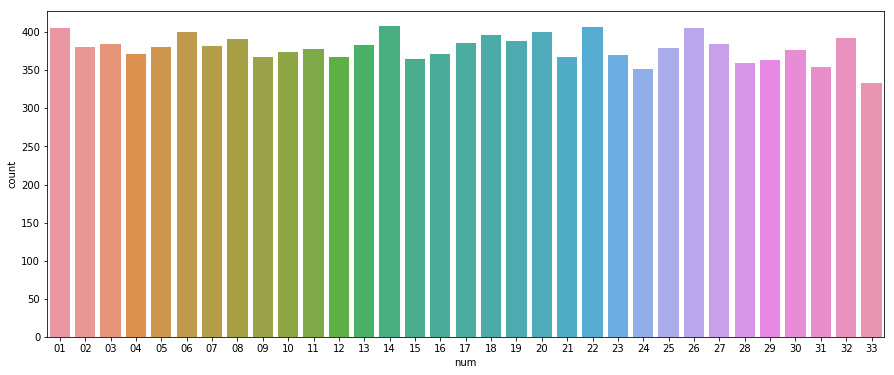

In [58]:
plt.figure(figsize=(15,6))
sns.countplot(x='num',data=df_merge);

In [69]:
df_merge.groupby('num').size().sort_values(ascending=False)

num
14    408
22    407
01    406
26    406
20    401
06    400
18    396
32    392
08    391
19    388
17    386
27    385
03    384
13    383
07    382
02    381
05    380
25    379
11    378
30    377
10    374
16    372
04    372
23    370
09    368
21    368
12    367
15    365
29    363
28    359
31    355
24    352
33    333
dtype: int64

In [65]:
blue=pd.DataFrame(df.iloc[:,6])

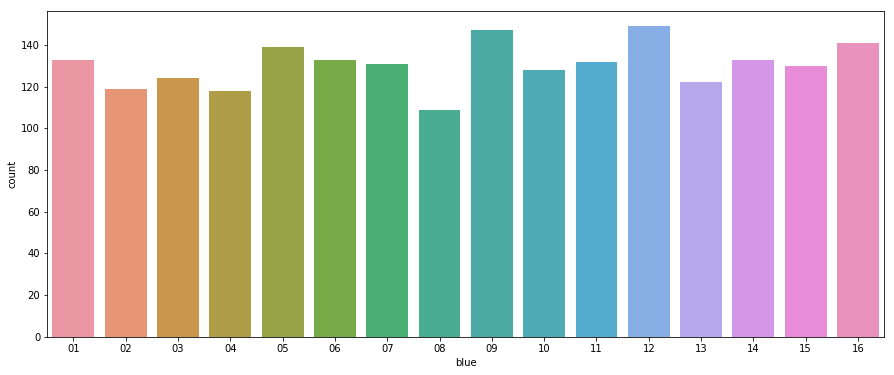

In [67]:
blue.columns=['blue']
plt.figure(figsize=(15,6))
sns.countplot(x='blue',data=blue);

In [70]:
blue.groupby('blue').size().sort_values(ascending=False)

blue
12    149
09    147
16    141
05    139
14    133
06    133
01    133
11    132
07    131
15    130
10    128
03    124
13    122
02    119
04    118
08    109
dtype: int64